## Experiment: segment 3D Volume slice by slice, then combine labels

This experiment is inspired by this discussion:

https://forum.image.sc/t/2d-3d-integer-labels/38732/10



In [1]:
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from csbdeep.utils import Path, normalize
import napari
from napari.utils import nbscreenshot
from tifffile import imread
import matplotlib.pyplot as plt
import numpy as np
from skimage.util._map_array import ArrayMap
from skimage import measure
from scipy import spatial
import tqdm
from skimage.segmentation import relabel_sequential
%gui qt

Using TensorFlow backend.


In [2]:
model_versatile = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [3]:
vol = imread("C:/Users/Volker/Data/Natasha/stardist_test.tif")
vol.shape

(215, 155, 179)

In [4]:
viewer = napari.view_image(vol)

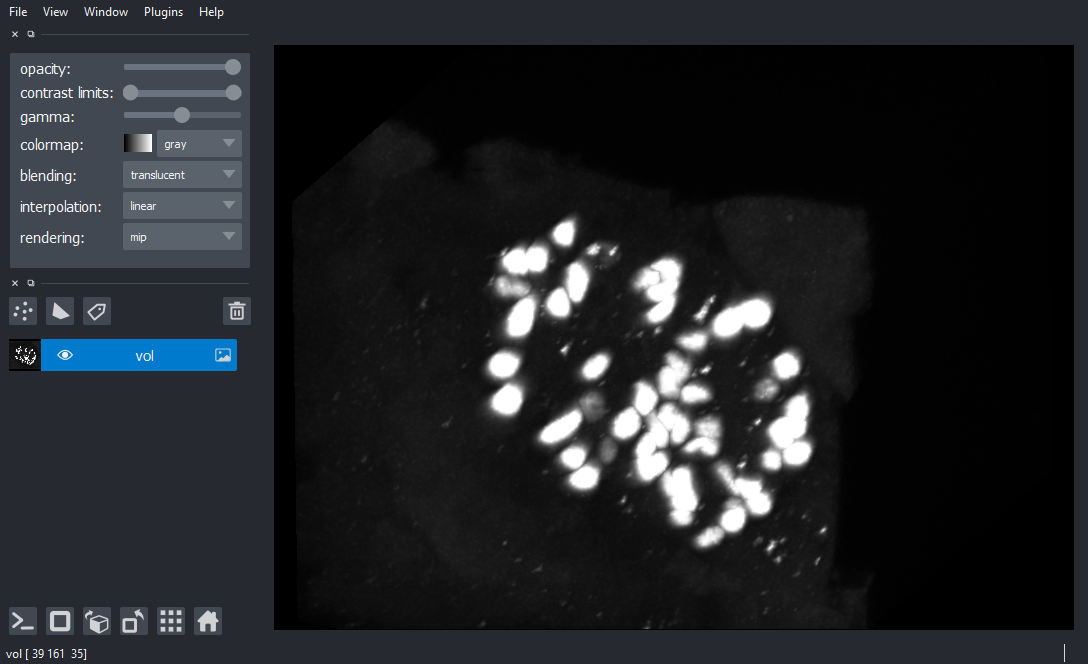

In [44]:
nbscreenshot(viewer)

Use Stardist on each slice:

In [5]:
img = normalize(vol[...], 10,99.8) #, axis=axis_norm)
results=[]
for im in img:
    labels, details = model_versatile.predict_instances(im)
    results.append(labels)

label_slices=np.array(results)

In [6]:
viewer.add_labels(label_slices)

<Labels layer 'label_slices' at 0x23d47080408>

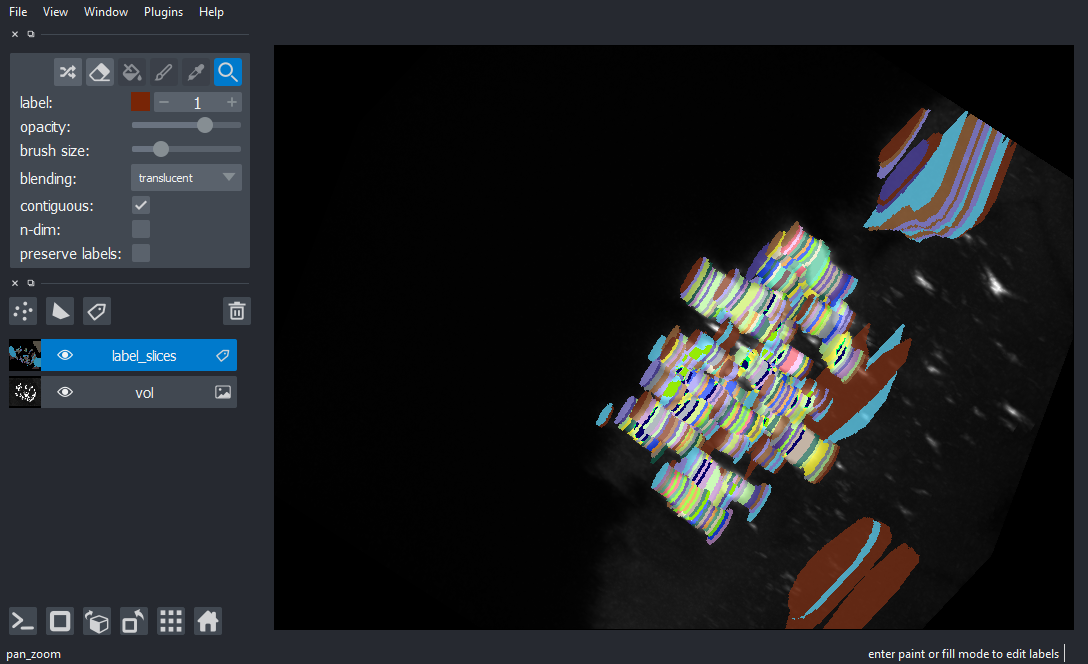

In [48]:
nbscreenshot(viewer)

Experiments with Martin Weigerts suggestion in the thread:

In [7]:
from stardist.matching import matching  
res = matching(label_slices[50],label_slices[51], report_matches=True)

print(res.matched_pairs)
print(res.matched_scores)

((1, 2), (2, 3), (3, 1), (4, 4), (5, 6), (6, 7), (7, 5), (8, 9), (9, 8))
(0.8695652173913043, 0.6962962962962963, 0.775, 0.9785714285714285, 0.8676470588235294, 0.8939393939393939, 0.8674698795180723, 0.7048192771084337, 0.9230769230769231)


In [8]:
viewer.add_labels(label_slices[50])

<Labels layer 'Labels' at 0x23d64427408>

In [9]:
viewer.add_labels(label_slices[51])

<Labels layer 'Labels [1]' at 0x23d53c5e948>

In [10]:
np.array(res.matched_pairs)[:,1]

array([2, 3, 1, 4, 6, 7, 5, 9, 8])

In [11]:
amap = ArrayMap(np.array(res.matched_pairs)[:,0],np.array(res.matched_pairs)[:,1])

In [12]:
viewer.add_labels(amap[label_slices[50]])

<Labels layer 'Labels [2]' at 0x23d53c36108>

`stardist.matching` only returns matches, i.e. any non-matches are lost when we do  ArrayMap  !
This needs some more bookkeeping code in order to work for this application.

## Experiments with kapoorlab's code snippet


below is the code snippet suggested by @kapoorlab in the thread:


In [25]:
def RelabelZ(previousImage, currentImage,threshold):
    relabelimage = currentImage
    waterproperties = measure.regionprops(previousImage, previousImage)
    indices = [prop.centroid for prop in waterproperties] 
    if len(indices) > 2:
       tree = spatial.cKDTree(indices)
       currentwaterproperties = measure.regionprops(currentImage, currentImage)
       currentindices = [prop.centroid for prop in currentwaterproperties] 
       if len(currentindices) > 2:
           for i in range(0,len(currentindices)):
               index = currentindices[i]
               currentlabel = currentImage[int(index[0]), int(index[1])]  
               if currentlabel > 0:
                      previouspoint = tree.query(index)
                      previouslabel = previousImage[int(indices[previouspoint[1]][0]), int(indices[previouspoint[1]][1])]
                      if previouspoint[0] > threshold:
                             relabelimage[np.where(currentImage == currentlabel)] = currentlabel
                      else:
                             relabelimage[np.where(currentImage == currentlabel)] = previouslabel
    return relabelimage 

Here I wrote a quick and dirty function that applies this to a whole stack (slice by slice):

In [22]:
def merge_labels_across_volume(labelvol, relabelfunc, threshold=3):
    nz, ny, nx = labelvol.shape
    res = np.zeros_like(labelvol)
    res[0,...] = labelvol[0,...]
    backup = labelvol.copy() # kapoors code modifies the input array
    for i in tqdm.tqdm(range(nz-1)):
        res[i+1] = relabelfunc(res[i,...], labelvol[i+1,...],threshold=threshold)
        labelvol = backup.copy() # restore the input array
    return res

In [28]:
relabelled_kapoor = merge_labels_across_volume(label_slices, RelabelZ)
viewer.add_labels(relabelled_kapoor, name="label merge Kapoor")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:04<00:00, 51.13it/s]


<Labels layer 'label merge Kapoor' at 0x23d68d7c748>

When we inspect the result we see that there are still some issues.


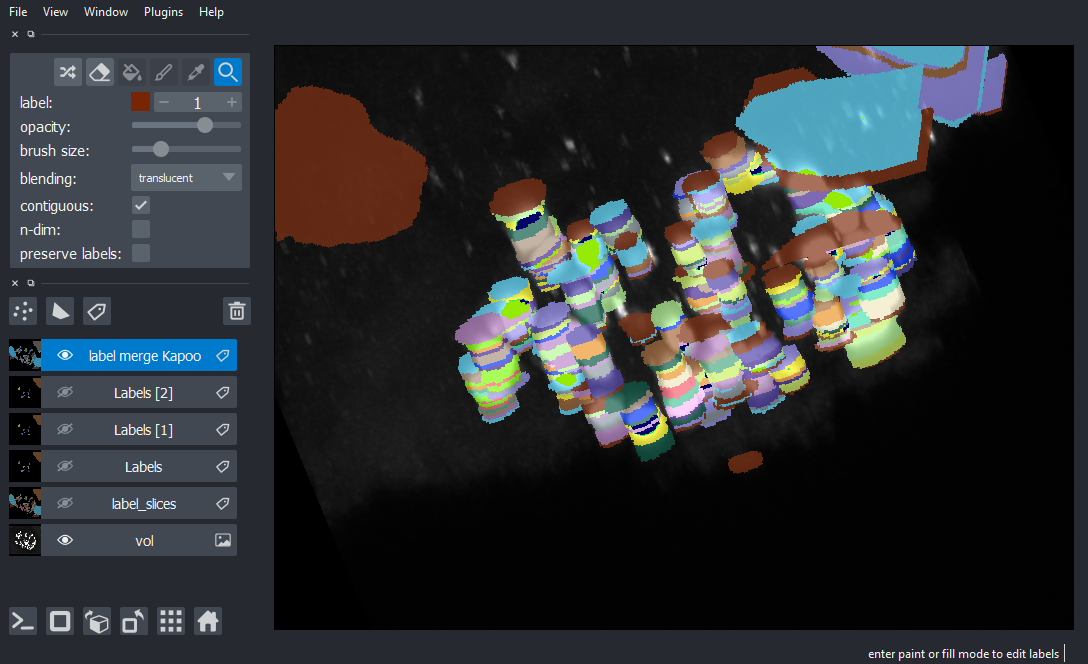

In [30]:
nbscreenshot(viewer)

When I looked into it I found that when there are unmatched object the merged image may contain several objects with the same label.
This can be addressed by relabelling one of the images first such that both images have non-intersecting label sets.

In [17]:
def RelabelZ_with_fixes(previousImage, currentImage,threshold):
    # This line ensures non-intersecting label sets
    currentImage = relabel_sequential(currentImage,offset=previousImage.max()+1)[0]
    # I also don't like modifying the input image, so we take a copy
    relabelimage = currentImage.copy()
    waterproperties = measure.regionprops(previousImage, previousImage)
    indices = [prop.centroid for prop in waterproperties] 
    labels = [prop.label for prop in waterproperties]
    if len(indices) > 2:
       tree = spatial.cKDTree(indices)
       currentwaterproperties = measure.regionprops(currentImage, currentImage)
       currentindices = [prop.centroid for prop in currentwaterproperties] 
       currentlabels = [prop.label for prop in currentwaterproperties] 
       if len(currentindices) > 2: #why only > : ?
           for i in range(0,len(currentindices)):
               index = currentindices[i]
               print(f"index {index}")
               currentlabel = currentlabels[i] 
               print(f"currentlabel {currentlabel}")
               if currentlabel > 0:
                      previouspoint = tree.query(index)
                      print(f"prviouspoint {previouspoint}")
                      previouslabel = previousImage[int(indices[previouspoint[1]][0]), int(indices[previouspoint[1]][1])]
                      print(f"previouslabels {previouslabel}")
                      if previouspoint[0] > threshold:
                             relabelimage[np.where(currentImage == currentlabel)] = currentlabel
                      else:
                             relabelimage[np.where(currentImage == currentlabel)] = previouslabel
    return relabelimage 

In [31]:
relabelled_fixes = merge_labels_across_volume(label_slices, RelabelZ_with_fixes)
viewer.add_labels(relabelled_fixes, name="Kapoor with fixes")

 25%|███████████████████████████▊                                                                                  | 54/214 [00:01<00:03, 47.18it/s]

index (80.17948717948718, 106.28205128205128)
currentlabel 12
prviouspoint (7.0460156326125345, 2)
previouslabels 10
index (81.75324675324676, 82.16883116883118)
currentlabel 13
prviouspoint (28.036482139325138, 2)
previouslabels 10
index (21.00251572327044, 161.8748427672956)
currentlabel 14
prviouspoint (0.8613674620355447, 1)
previouslabels 9
index (58.47715736040609, 56.23857868020305)
currentlabel 15
prviouspoint (1.0527545588866225, 0)
previouslabels 8
index (86.7, 110.33333333333333)
currentlabel 16
prviouspoint (0.6600315688796012, 2)
previouslabels 10
index (66.68539325842697, 113.57303370786516)
currentlabel 17
prviouspoint (0.4976951620388149, 3)
previouslabels 11
index (79.79411764705883, 106.08823529411765)
currentlabel 14
prviouspoint (0.431363319839251, 4)
previouslabels 12
index (106.1304347826087, 111.15942028985508)
currentlabel 15
prviouspoint (19.447987440888205, 2)
previouslabels 10
index (20.8782874617737, 161.3400611620795)
currentlabel 16
prviouspoint (0.5490209

 28%|██████████████████████████████▎                                                                               | 59/214 [00:01<00:03, 41.42it/s]

index (119.12244897959184, 112.22448979591837)
currentlabel 20
prviouspoint (12.23870455469083, 5)
previouslabels 15
index (79.2051282051282, 106.1025641025641)
currentlabel 21
prviouspoint (0.32821514407794916, 9)
previouslabels 19
index (96.74285714285715, 101.42857142857143)
currentlabel 22
prviouspoint (0.07106345166106028, 8)
previouslabels 18
index (21.01017964071856, 161.07904191616765)
currentlabel 23
prviouspoint (0.15325238996523075, 1)
previouslabels 9
index (98.2127659574468, 88.31914893617021)
currentlabel 24
prviouspoint (0.0, 6)
previouslabels 16
index (104.18604651162791, 72.83720930232558)
currentlabel 25
prviouspoint (0.32304085625196627, 7)
previouslabels 17
index (85.83673469387755, 109.73469387755102)
currentlabel 26
prviouspoint (0.2857370617743984, 2)
previouslabels 10
index (106.8125, 112.03125)
currentlabel 27
prviouspoint (0.07276213453150747, 5)
previouslabels 15
index (82.21794871794872, 83.57692307692308)
currentlabel 28
prviouspoint (0.14406046250555812, 4

 30%|████████████████████████████████▉                                                                             | 64/214 [00:01<00:03, 37.65it/s]


currentlabel 26
prviouspoint (14.801670971723736, 8)
previouslabels 20
index (85.4342105263158, 143.0921052631579)
currentlabel 27
prviouspoint (22.406869012297445, 9)
previouslabels 22
index (54.82692307692308, 118.3076923076923)
currentlabel 28
prviouspoint (0.23806283765839195, 10)
previouslabels 23
index (105.59615384615384, 73.34615384615384)
currentlabel 29
prviouspoint (0.21392594258033504, 6)
previouslabels 17
index (106.92592592592592, 136.61111111111111)
currentlabel 30
prviouspoint (0.04153099640202724, 9)
previouslabels 22
index (119.8913043478261, 113.47826086956522)
currentlabel 31
prviouspoint (0.9597278284627917, 8)
previouslabels 20
index (94.48979591836735, 101.46938775510205)
currentlabel 32
prviouspoint (0.6889986458814139, 7)
previouslabels 18
index (105.625, 111.4375)
currentlabel 33
prviouspoint (0.5762215285808054, 5)
previouslabels 15
index (55.611111111111114, 55.144444444444446)
currentlabel 34
prviouspoint (0.30343714302548996, 0)
previouslabels 8
index (70

 32%|██████████████████████████████████▉                                                                           | 68/214 [00:01<00:04, 33.43it/s]

index (118.69047619047619, 112.66666666666667)
currentlabel 52
prviouspoint (0.45306553815375444, 4)
previouslabels 20
index (112.90243902439025, 136.70731707317074)
currentlabel 53
prviouspoint (0.43368580894880976, 13)
previouslabels 38
index (91.66666666666667, 102.18181818181819)
currentlabel 54
prviouspoint (0.5614131055053442, 3)
previouslabels 18
index (27.013422818791945, 166.72706935123043)
currentlabel 55
prviouspoint (2.4061391541425348, 15)
previouslabels 45
index (105.88888888888889, 137.36111111111111)
currentlabel 56
prviouspoint (0.3410012979812079, 5)
previouslabels 22
index (101.82692307692308, 61.05769230769231)
currentlabel 57
prviouspoint (0.3797109427176947, 9)
previouslabels 30
index (53.89473684210526, 54.62105263157895)
currentlabel 58
prviouspoint (0.27756454341164455, 0)
previouslabels 8
index (41.21621621621622, 53.945945945945944)
currentlabel 59
prviouspoint (0.4398727753014654, 17)
previouslabels 50
index (70.77049180327869, 141.80327868852459)
currentlab

 36%|███████████████████████████████████████                                                                       | 76/214 [00:01<00:04, 30.39it/s]

index (101.09756097560975, 63.03658536585366)
currentlabel 62
prviouspoint (0.3310379441873626, 3)
previouslabels 30
index (116.73214285714286, 72.42857142857143)
currentlabel 63
prviouspoint (0.12298171626649004, 5)
previouslabels 35
index (81.1830985915493, 148.05633802816902)
currentlabel 64
prviouspoint (0.5300234050592085, 12)
previouslabels 55
index (69.61538461538461, 142.25)
currentlabel 65
prviouspoint (0.6088309682736217, 2)
previouslabels 28
index (90.49122807017544, 145.2982456140351)
currentlabel 66
prviouspoint (0.9934992363388783, 1)
previouslabels 27
index (41.14473684210526, 53.9078947368421)
currentlabel 67
prviouspoint (0.5151898374249191, 10)
previouslabels 50
index (94.85, 42.6875)
currentlabel 68
prviouspoint (0.05303300858899809, 6)
previouslabels 37
index (51.01190476190476, 126.28571428571429)
currentlabel 69
prviouspoint (0.05743416778250451, 8)
previouslabels 39
index (121.50847457627118, 128.42372881355934)
currentlabel 70
prviouspoint (0.22320059939495482, 

 37%|█████████████████████████████████████████                                                                     | 80/214 [00:01<00:04, 28.61it/s]

index (116.28888888888889, 72.46666666666667)
currentlabel 84
prviouspoint (0.3426589024916585, 4)
previouslabels 35
index (56.1875, 94.0)
currentlabel 85
prviouspoint (0.7395280872543903, 19)
previouslabels 74
index (98.87719298245614, 64.6140350877193)
currentlabel 86
prviouspoint (0.3063903367819875, 3)
previouslabels 30
index (47.88732394366197, 42.014084507042256)
currentlabel 87
prviouspoint (0.35742546231971617, 18)
previouslabels 72
index (50.0, 66.46753246753246)
currentlabel 88
prviouspoint (0.26355954687641564, 12)
previouslabels 57
index (114.44594594594595, 88.89189189189189)
currentlabel 89
prviouspoint (0.05663194126431901, 17)
previouslabels 70
index (86.44262295081967, 35.967213114754095)
currentlabel 90
prviouspoint (0.2525296000822871, 16)
previouslabels 68
index (40.70175438596491, 52.771929824561404)
currentlabel 91
prviouspoint (0.45463827438518106, 8)
previouslabels 50
index (131.77586206896552, 117.77586206896552)
currentlabel 92
prviouspoint (0.2211022039728789

 40%|████████████████████████████████████████████▏                                                                 | 86/214 [00:02<00:04, 27.99it/s]

index (105.56521739130434, 105.47826086956522)
currentlabel 86
prviouspoint (16.371147760140104, 11)
previouslabels 66
index (100.76388888888889, 60.02777777777778)
currentlabel 87
prviouspoint (5.890689583183964, 2)
previouslabels 30
index (93.18181818181819, 43.03896103896104)
currentlabel 88
prviouspoint (0.5232770718737455, 4)
previouslabels 37
index (89.89333333333333, 142.92)
currentlabel 89
prviouspoint (0.7618690467819738, 0)
previouslabels 27
index (117.10204081632654, 133.79591836734693)
currentlabel 90
prviouspoint (0.2461674003914137, 10)
previouslabels 63
index (90.04545454545455, 88.84848484848484)
currentlabel 91
prviouspoint (0.22140542569461294, 16)
previouslabels 76
index (126.56716417910448, 120.65671641791045)
currentlabel 92
prviouspoint (0.3609966155954546, 19)
previouslabels 84
index (48.720588235294116, 66.05882352941177)
currentlabel 93
prviouspoint (0.4502767113311934, 8)
previouslabels 57
index (56.61666666666667, 38.95)
currentlabel 94
prviouspoint (0.800926

 42%|█████████████████████████████████████████████▋                                                                | 89/214 [00:02<00:04, 27.17it/s]

index (96.8, 133.9111111111111)
currentlabel 94
prviouspoint (7.501034020462871, 0)
previouslabels 27
index (43.57142857142857, 91.51020408163265)
currentlabel 95
prviouspoint (0.5067479311113103, 20)
previouslabels 91
index (79.24691358024691, 147.54320987654322)
currentlabel 96
prviouspoint (0.7836146413539915, 3)
previouslabels 55
index (118.21428571428571, 102.69642857142857)
currentlabel 97
prviouspoint (0.5159103126265198, 7)
previouslabels 66
index (65.5079365079365, 51.65079365079365)
currentlabel 98
prviouspoint (0.7253985620485648, 19)
previouslabels 90
index (47.254901960784316, 65.72549019607843)
currentlabel 99
prviouspoint (0.14914545769463292, 4)
previouslabels 57
index (100.87012987012987, 98.87012987012987)
currentlabel 100
prviouspoint (1.2739065273285584, 18)
previouslabels 88
index (105.54166666666667, 106.77083333333333)
currentlabel 101
prviouspoint (0.594473524530333, 16)
previouslabels 86
index (51.666666666666664, 91.05555555555556)
currentlabel 102
prviouspoin

 44%|████████████████████████████████████████████████▊                                                             | 95/214 [00:02<00:04, 27.63it/s]

index (85.32758620689656, 36.55172413793103)
currentlabel 110
prviouspoint (0.2301450459352609, 2)
previouslabels 68
index (47.69642857142857, 40.42857142857143)
currentlabel 111
prviouspoint (0.0, 4)
previouslabels 72
index (89.575, 101.65)
currentlabel 112
prviouspoint (0.16007810593581767, 16)
previouslabels 108
index (89.09803921568627, 62.470588235294116)
currentlabel 113
prviouspoint (0.6973912846232333, 15)
previouslabels 106
index (80.05263157894737, 96.3859649122807)
currentlabel 114
prviouspoint (0.17873500460257608, 12)
previouslabels 95
index (100.4920634920635, 92.31746031746032)
currentlabel 115
prviouspoint (0.494280163615022, 13)
previouslabels 98
index (101.58571428571429, 99.32857142857142)
currentlabel 116
prviouspoint (0.5508505918575527, 9)
previouslabels 88
index (106.04615384615384, 108.70769230769231)
currentlabel 117
prviouspoint (0.30039216855918316, 7)
previouslabels 86
index (53.42857142857143, 92.11904761904762)
currentlabel 118
prviouspoint (0.436485735921

 46%|██████████████████████████████████████████████████▉                                                           | 99/214 [00:02<00:03, 28.87it/s]

prviouspoint (0.3985741344838145, 9)
previouslabels 116
index (80.3, 95.8)
currentlabel 118
prviouspoint (0.12806248474866258, 3)
previouslabels 95
index (100.34328358208955, 92.58208955223881)
currentlabel 119
prviouspoint (0.6505298920398311, 4)
previouslabels 98
index (103.33333333333333, 107.15873015873017)
currentlabel 120
prviouspoint (0.1324499260511142, 1)
previouslabels 86
index (91.58181818181818, 101.87272727272727)
currentlabel 121
prviouspoint (0.3460824034512035, 7)
previouslabels 108
index (95.25531914893617, 137.32978723404256)
currentlabel 122
prviouspoint (0.23211902074773744, 0)
previouslabels 27
index (89.55, 62.916666666666664)
currentlabel 123
prviouspoint (0.17898606392771302, 6)
previouslabels 106
index (66.27272727272727, 51.872727272727275)
currentlabel 124
prviouspoint (0.04887869004486902, 2)
previouslabels 90
index (106.66666666666667, 76.26666666666667)
currentlabel 125
prviouspoint (0.3010395449656294, 5)
previouslabels 105
index (48.56410256410256, 93.28

 50%|███████████████████████████████████████████████████████                                                      | 108/214 [00:02<00:03, 33.34it/s]

index (93.30952380952381, 137.38095238095238)
currentlabel 119
prviouspoint (0.5679912688107572, 0)
previouslabels 27
index (101.61016949152543, 106.7457627118644)
currentlabel 120
prviouspoint (0.32381310465326124, 1)
previouslabels 86
index (99.43055555555556, 91.95833333333333)
currentlabel 121
prviouspoint (0.473538542460983, 3)
previouslabels 98
index (90.18333333333334, 101.88333333333334)
currentlabel 122
prviouspoint (0.41965594373379767, 6)
previouslabels 108
index (64.65625, 51.46875)
currentlabel 123
prviouspoint (0.14933203925524716, 2)
previouslabels 90
index (105.07462686567165, 76.0)
currentlabel 124
prviouspoint (0.6443126203963274, 4)
previouslabels 105
index (88.43859649122807, 63.6140350877193)
currentlabel 125
prviouspoint (0.01647922341701948, 5)
previouslabels 106
index (47.472527472527474, 92.35164835164835)
currentlabel 126
prviouspoint (1.0584234452113008, 7)
previouslabels 115
index (85.94915254237289, 92.35593220338983)
currentlabel 127
prviouspoint (0.071251

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 42.53it/s]


<Labels layer 'Kapoor with fixes' at 0x23d012820c8>

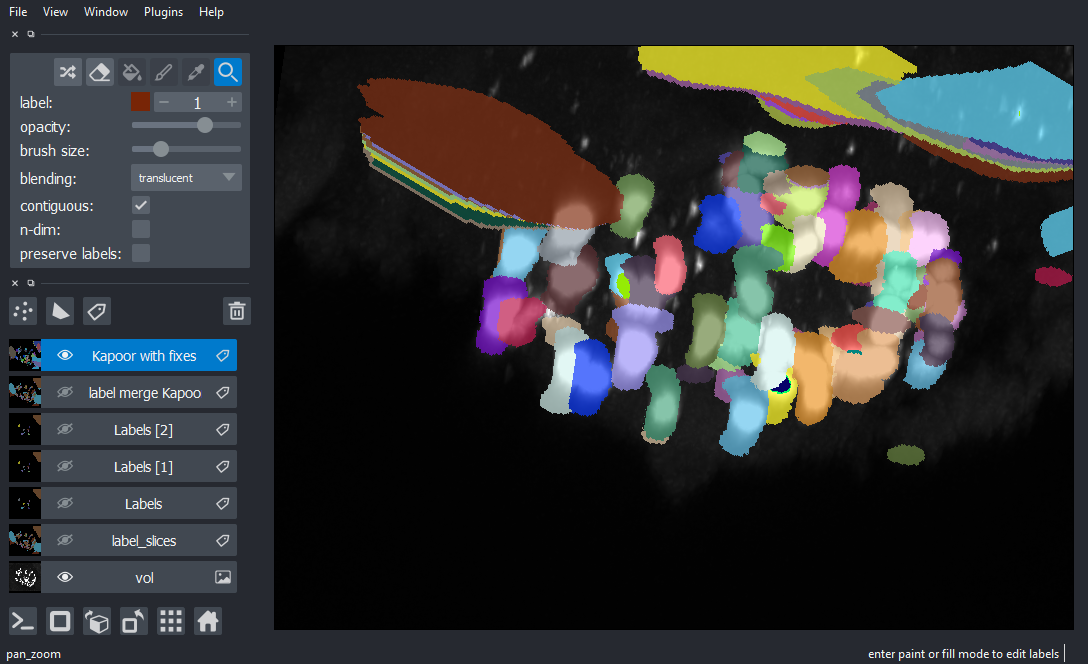

In [32]:
nbscreenshot(viewer)